In [16]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from utils import *
from keras.applications import ResNet50V2

In [2]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :
val :
test :


In [18]:
n_frames = 2
fc_hidden1 = 512
fc_hidden2 = 256
batch_size = 8

output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(), dtype=tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature=output_signature)

# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature=output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature=output_signature)

test_ds = test_ds.batch(batch_size)

# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

# Create the ResNet50 base model
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(HEIGHT, WIDTH, 3))

# Freeze the weights of the base model
base_model.trainable = False

# Create the input layer for the sequence of frames
input_shape = (n_frames, HEIGHT, WIDTH, 3)
input_frames = layers.Input(shape=input_shape)

# Apply the base model to each frame in the sequence
encoded_frames = layers.TimeDistributed(base_model)(input_frames)

# Reshape the encoded frames to match the LSTM input shape
reshaped_frames = layers.Reshape((n_frames, -1))(encoded_frames)

# Apply LSTM layer to process the sequence
x = layers.LSTM(64)(reshaped_frames)

# Add a dense layer for classification
output = layers.Dense(10)(x)

# Create the model
model = keras.Model(input_frames, output)

# Compile the model
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Print the model summary
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 2, 224, 224, 3)]  0         
                                                                 
 time_distributed_1 (TimeDis  (None, 2, 7, 7, 2048)    23564800  
 tributed)                                                       
                                                                 
 reshape_9 (Reshape)         (None, 2, 100352)         0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                25706752  
                                                                 
 dense_18 (Dense)            (None, 10)                650       
                                                                 
Total params: 49,272,202
Trainable params: 25,707,402
Non-trainable params: 23,564,800
______________________________________

In [20]:
history = model.fit(x = train_ds,
                    epochs = 10, 
                    validation_data = val_ds)

Epoch 1/10


38/38 [==============================] - 14s 364ms/step - loss: 0.0746 - accuracy: 1.0000 - val_loss: 0.2586 - val_accuracy: 0.9200
Epoch 2/10
38/38 [==============================] - 14s 371ms/step - loss: 0.0534 - accuracy: 1.0000 - val_loss: 0.2170 - val_accuracy: 0.9400
Epoch 3/10
38/38 [==============================] - 14s 380ms/step - loss: 0.0438 - accuracy: 1.0000 - val_loss: 0.2552 - val_accuracy: 0.9000
Epoch 4/10
38/38 [==============================] - 14s 374ms/step - loss: 0.0283 - accuracy: 1.0000 - val_loss: 0.1743 - val_accuracy: 0.9400
Epoch 5/10
38/38 [==============================] - 14s 373ms/step - loss: 0.0273 - accuracy: 0.9967 - val_loss: 0.1644 - val_accuracy: 0.9500
Epoch 6/10
38/38 [==============================] - 14s 381ms/step - loss: 0.0297 - accuracy: 0.9967 - val_loss: 0.2415 - val_accuracy: 0.8900
Epoch 7/10
38/38 [==============================] - 14s 376ms/step - loss: 0.0192 - accuracy: 1.0000 - val_loss: 0.1591 - val_accuracy: 0.9500
Epoch 8/10

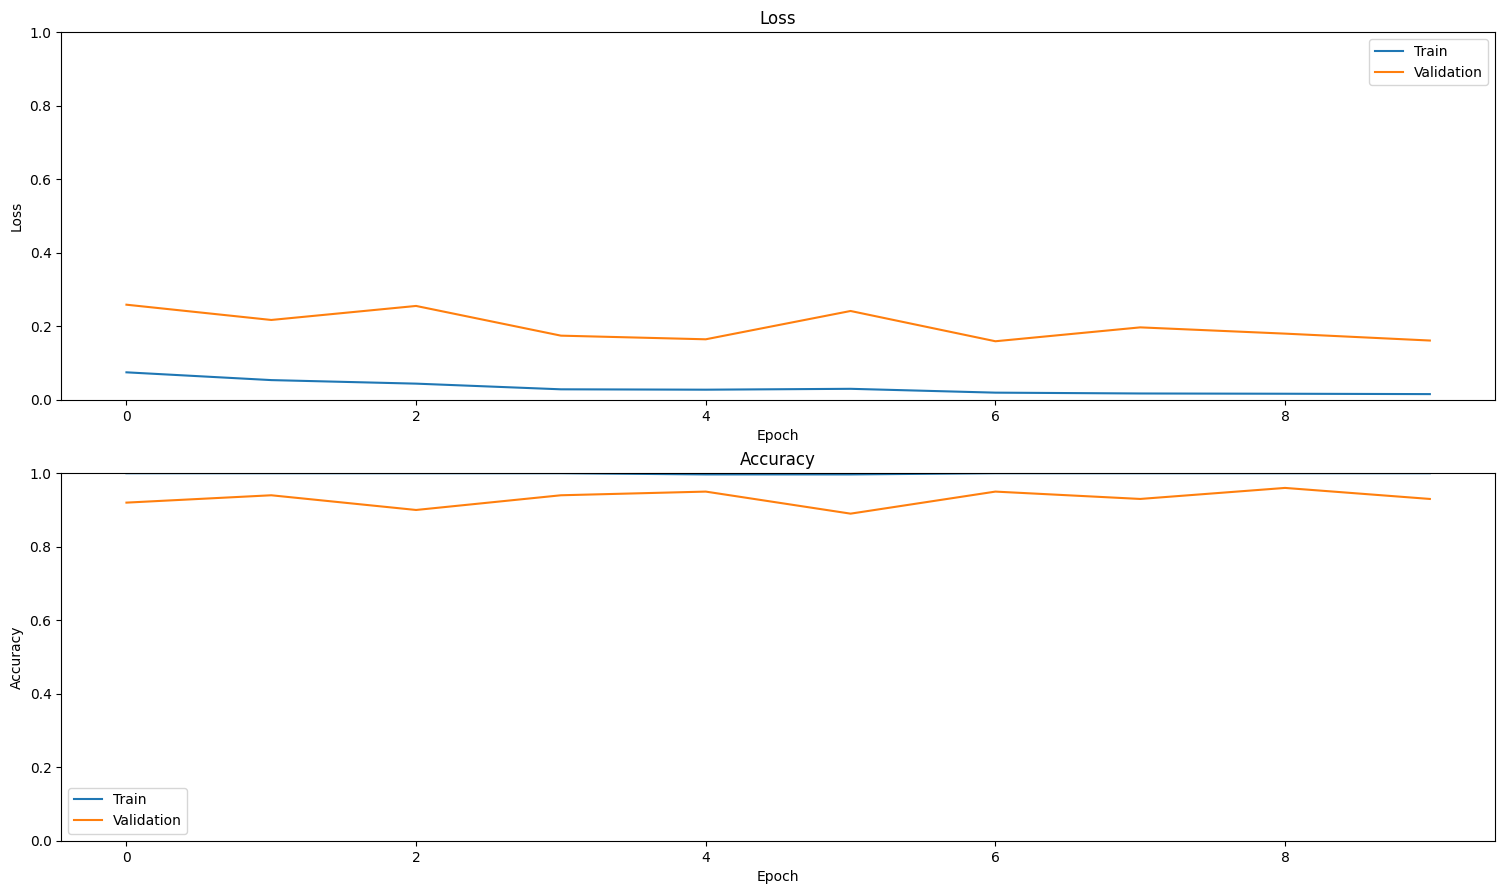

In [21]:
plot_history(history)

In [22]:

model.evaluate(test_ds, return_dict=True)

13/13 [==============================] - 4s 283ms/step - loss: 0.1207 - accuracy: 0.9800


{'loss': 0.12071071565151215, 'accuracy': 0.9800000190734863}

13/13 [==============================] - 5s 238ms/step


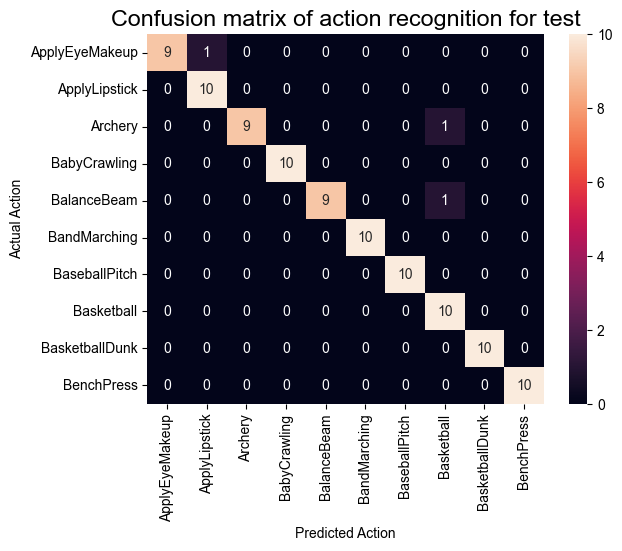

In [23]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')